# Consistent scores

A "consistent scoring function" is a scoring function where following a forecast directive will optimise the forecaster's expected score. It is important to use consistent scoring functions to avoid the "forecaster's dilemma" ([Lerch et al., 2017](https://projecteuclid.org/journals/statistical-science/volume-32/issue-1/Forecasters-Dilemma-Extreme-Events-and-Forecast-Evaluation/10.1214/16-STS588.full)) (i.e., should a forecaster issue an honest forecast or should they issue one that optimises their expected score?). Consistent scoring rules are formally defined in([Gneiting et al., 2011](https://www.tandfonline.com/doi/abs/10.1198/jasa.2011.r10138)).


The MSE is a consistent score for forecasting the mean and the MAE is a consistent score for forecasting the median. But did you know that there are a whole family of scores that are consistent for prediciting the mean, median, or a quantile? 

`score`'s consistent scoring module provides access to these families of consistent scores that can we used to emphasise predictive performance across desired decision thresholds.

### Example 1. A score consistent with the mean
Let's jump into an example that illustrates a scoring function that is consistent with predicting the mean value using `scores`. Suppose we want to evaluate the performance of expected daily precipitation forecasts, but we want to place increasing importance on correctly forecasting extreme values. 


We want to used the `consistent_expectile_score` in `scores` to evaluate the expected daily precipitation forecasts. Note that medians relate to quantiles in an analogous way to how the mean relates to [expectiles](https://en.wikipedia.org/wiki/Expectile).

Our consistent scoring function for expectiles is 

 $$ S(x, y) =
    \begin{cases}
    (1 - \alpha)(\phi(y) - \phi(x) - \phi'(x)(y-x)), & y < x \\
    \alpha(\phi(y) - \phi(x) - \phi'(x)(y-x)), & x \leq y
    \end{cases}
$$

Where:
- $x$ is the forecast
- $y$ is the observation
- $\alpha$ is the expectile level
- $\phi$ is a [convex function](https://en.wikipedia.org/wiki/Convex_function) of a single variable
- $\phi'$ is the [subderivative](https://en.wikipedia.org/wiki/Subderivative) of $\phi$. The subderivative is a generalisation of the derivative for convex functions and coincides with the derivative when the convex function is differentiable
- $S(x,y)$ is the score.

To make the expectile the consistent with the mean, set $\alpha=0.5$.

Next we need to determine our $\phi(z)$ and $\phi'(z)$ functions. Let's assume that that the importance of predicting extreme rainfall increases exponentially.

First we create the weighting function

$$\phi''(z) = \exp ^\frac{z}{10}$$ 

This will place increasing importance on more extreme rainfall thresholds.

Next we need to integrate $\phi''(z)$ twice so that we can derive the functions for our consistent scoring function.

$$\phi'(z) = 10\exp ^\frac{z}{10}$$ 
and 
$$\phi(z) = z + 100\exp ^\frac{z}{10}$$ 

These equations can be substituted in $ S(x, y)$. Note that to use the `consistent_expectile_score` in scores, you only need to define $\phi(s)$ and $\phi'(s)$, but not $S(x, y)$.

Let's illustrate how this can be done in scores using some synthetic rainfall data.

In [63]:
from scores.continuous import consistent_expectile_score, mse, murphy_score, murphy_thetas
import matplotlib.pyplot as plt
from scipy.stats import skewnorm
import numpy as np
import pandas as pd
import xarray as xr

In [ ]:
# First, let's visualise our weighting function



In [64]:
# define phi and phi prime
def phi_prime(z):
    """Phi prime"""
    return 10 * np.exp(z/10)

def phi(z):
    """Phi"""
    return z + 100 * np.exp(z/10)

In [65]:
# Generate some synthetic data
lat = np.linspace(-90, 90, 10)
lon = np.linspace(-180, 180, 20)
times = pd.date_range('2023-11-19', periods=5)

forecast = np.random.uniform(0, 100, size=(len(lat), len(lon), len(times)))
forecast = xr.DataArray(
    forecast,
    dims=('lat', 'lon', 'time'),
    coords={'lat': lat, 'lon': lon, 'time': times}
)

obs = forecast + np.random.random((len(lat), len(lon), len(times)))
obs = obs.clip(min=0)
obs = xr.DataArray(
    obs,
    dims=('lat', 'lon', 'time'),
    coords={'lat': lat, 'lon': lon, 'time': times}
)

# Generate some synthetic rainfall observations between 0 and 50mm
N = 1000
obs = xr.DataArray(data=50 * np.random.random(N), dims=["time"], coords={"time": np.arange(0, N)})
obs = obs.clip(min=0) # don't allow negative rainfall

# Generate synthetic forecasts by adding noise to each observation
fcst1 = 0.9 * obs + skewnorm.rvs(4, size=N) # fcst1 has a low bias
fcst1 = fcst1.clip(min=0)
fcst2 = 1.1 * obs - skewnorm.rvs(4, size=N) # fcst2 has a high bias
fcst2 = fcst2.clip(min=0)

In [66]:
# First if we calculate the MSE of fcst1 and fcst2 we will see that that have similar predictive performance.
print(f"fcst1 MSE = {mse(fcst1, obs).item()}")
print(f"fcst2 MSE = {mse(fcst2, obs).item()}")

fcst1 MSE = 5.409273880511562
fcst2 MSE = 5.381503500627776


In [67]:
# However, when we calculate the performance of these forecasts with increasing focus on 
# extreme decision thresholds, we see that the performance is quite different.
fcst1_cons_score = consistent_expectile_score(fcst1, obs, alpha=0.5, phi=phi, phi_prime=phi_prime).item()
fcst2_cons_score = consistent_expectile_score(fcst2, obs, alpha=0.5, phi=phi, phi_prime=phi_prime).item()

print(f"fcst1 consistent score = {fcst1_cons_score}")
print(f"fcst2 consistent score = {fcst2_cons_score}")

fcst1 consistent score = 66.73338475772844
fcst2 consistent score = 108.92485052598764


Why is this? To visualise the difference in performance, we use plot Murphy Diagrams. See the [Murphy Diagrams tutorial](./Murphy_Diagrams.ipynb).

Text(0.5, 0.98, 'Murphy Score (for mean)')

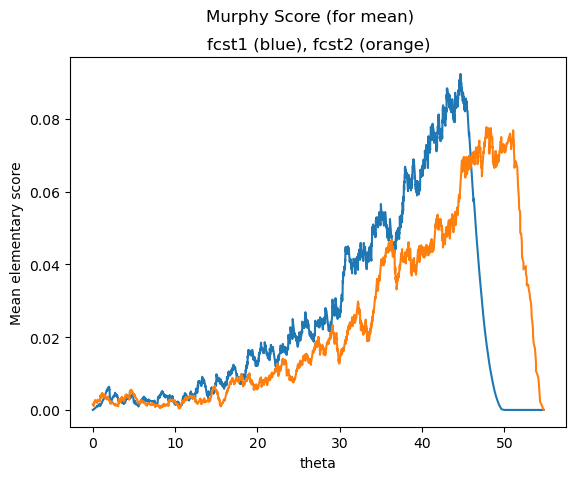

In [68]:
# Generate a list of thresholds of interest
thetas = murphy_thetas([fcst1, fcst2], obs, "expectile")

# Calculate the average elementary score for the mean (0.5 expectile) for each threshold theta
ms1 = murphy_score(fcst1, obs, thetas, functional="expectile", alpha=0.5)
ms2 = murphy_score(fcst2, obs, thetas, functional="expectile", alpha=0.5)

# Rename date variable for plotting
ms1 = ms1.rename({"total": "Mean elementary score"})
ms2 = ms2.rename({"total": "Mean elementary score"})

# Plot the results
ms1["Mean elementary score"].plot()
ms2["Mean elementary score"].plot()
plt.title('fcst1 (blue), fcst2 (orange)')
plt.suptitle('Murphy Score (for mean)')

Lower values are better on the Murphy Diagram. Fcst2 (orange) performs far worse at higher rainfall thresholds (denoted as "theta" on the plot), so is penalised more heavily due to out weighting function $\phi''(z) = \exp ^\frac{z}{10}$.